In [1]:
from pre_processing import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Error in setting maxSize for CSV output


In [2]:
lines = 0
all_lines = 5000010
percent = 0.10
ls = []

with open('./data/wiki_sampled_10p.txt','w',encoding="utf-8") as outfile:
    for i in range(5):
        with open('G:\\topic2vec\\wiki-articles\wiki'+str(i),'r',encoding='utf-8') as txtfile:
            for line in txtfile:
                if len(line) > 3:
                    ls.append(line)
                if len(ls) > 1000:
                    for d in np.random.permutation(1000)[0:int(percent*1000)]:
                        outfile.write(ls[d]+'\n')
                    ls = []
            
# print(lines)

In [1]:
def reading_results(res,topic_num,itreations):
  '''
  Reading result to get top terms and log-likelihood every 50 iterations

  returns: Log-Likelihood and all_top terms for each 50 iterations

  parameter res: all the command prompt prints and results (type:str)
  '''

  #reading the string
  current_line = 9#where to start in CSV file
  stp1 = topic_num+2#where to read Log-Likelihood
  stp2 = 6 #constant number of lines to get to topics again

  #please set the number of iteration to what you set for your topic model
  all_top_terms = []#storing all top terms
  LLs = []
  for _i in range(int(itreations/50)):
    #top_terms = []
    for i in range(topic_num):#reading top 
      try:
        #reading top terms splited by two tabs + the second split is for splitting the terms with space
        #excluding the last item using [0:-1].  because the last item is '\n'
        all_top_terms.append(res[current_line].split('\t')[2].split(' ')[0:-1])
      except:
        print(res[current_line-2:current_line+3],current_line)
      current_line+=1#going to next line
    current_line+=1 #going to LL
    if _i>3: #optimizing alpha would add [beta] update after 250 iterations and we want to add one line for that
      current_line +=1
    LLs.append(float(res[current_line].split(': ')[1]))
    current_line += stp2
    #all_top_terms.append(top_terms)
  return all_top_terms,LLs

from pre_processing import *
from lda_mallet import *
from post_processing import *

from os import walk

import subprocess

import random

import matplotlib.pyplot as plt
import seaborn as sns

import platform 
#checking OS
if 'windows' in platform.system().lower():
  python_cmd = "C:\\PROGRA~1\\Python37\\python.exe"
elif 'darwin' in platform.system().lower():
  python_cmd = 'python3'
else:
  python_cmd = 'python.exe'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Error in setting maxSize for CSV output


In [ ]:
#loading reference corpus
wiki_docs = loading_wiki_docs('./data/wiki_sampled_5p.txt')
pre_processed_wiki,no_var = preprocess_data(wiki_docs)
vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_wiki)

#loading the dataset we train the model on
text_df = newsgroup('./data/20newsgroup_preprocessed.csv')
# text_df = ap_corpus('./data/ap.txt')
doc_list = list(text_df.text_cleaned)
pre_processed_docs,filtered_docs = preprocess_data(doc_list)
vocab_dict_, doc_term_matrix_ = prepare_corpus(pre_processed_docs)

#running for one topic number
topic_num = 50
itreations = 4000
iter_stp = 50#LDA stops every 50 iterations and print LLs and top terms

all_top_terms = []#storing all top terms in one vector
all_lls = [] #all of Log-Likelihood values

for _ in range(3): #three runs
  res = subprocess.run([python_cmd, 'tm_run.py','--data','./data/ap.txt',
                        '--tech','lda','--num',str(topic_num),'--seed',
                        str(int(random.random()*100000)),'--iter',str(itreations)]
                        , stdout=subprocess.PIPE,stderr=subprocess.STDOUT).stdout.decode('utf-8')
  #we have to wait till subprocess.run finishes....
  
  # with open('t.csv','w') as csvfile:
  #   csvfile.write(res)

  # with open('t.csv','r') as csvfile:
  #   res = csvfile.readlines()
  res = res.split('\n')
  tts,LLs = reading_results(res,topic_num,itreations)
  all_lls.extend(LLs)
  all_top_terms.extend(tts)

#saving to keep in case of an Error
with open('LLs_iter_analysis.txt','w') as txtfile:
  for tt in all_lls:
    txtfile.write(str(tt)+'\n')
with open('top_terms_iter_analysis.txt','w') as txtfile:
  for tt in all_top_terms:
    txtfile.write(','.join(tt)+'\n')

print('LDA runs are finished!')

In [7]:
coherence = []

stats = pd.DataFrame(columns=['iterations','top_n','coherence','LL'])
#running all top-terms in one go!
for n in [5,10,15,20]:
  #we compute coherence scores for all topics, which is [topic_num * numnber of runs (3) * group of top terms (4 grpups: 5-10-15-20)]
  #we should compute the average for each run over all topics with same number of top terms
  cscore = CoherenceModel(topics=all_top_terms,dictionary=vocab_dict,texts=pre_processed_wiki,topn=n,coherence='c_npmi').get_coherence_per_topic()
  cscore = np.asarray(cscore).reshape(int(itreations/iter_stp)*3,topic_num) #3 : three runs
  coherence_avg = np.sum(cscore,axis=1)
  print(coherence_avg)

  c =0 #coherence counter
  for _ in range(3):#for three runs
    for it in range(int(itreations/iter_stp)):
      print([(it+1)*iter_stp,n,coherence_avg[c],all_lls[it]])
      stats = pd.concat([stats,pd.DataFrame(data=[[(it+1)*iter_stp,n,coherence_avg[c],all_lls[it]]],columns=['iterations','top_n','coherence','LL'])],ignore_index=True)
      c+=1 #adding coherence counter
  #save a copy
  stats.to_csv('LDA_stats.csv',index=False)
  print('All coherence compuation for top-{0} terms are computed'.format(n))


KeyError: 'bush'

In [32]:
from pre_processing import *
from lda_mallet import *
from post_processing import *

from os import walk


#reading data for ED corpus
# datafolder = './data/ed_recovery_formatted/Excel'
# #datafolder = 'ed_recovery_topicmodel'
# df = pd.DataFrame(columns=['url','type','photo','date','tags','notes','text','photo_url','reblogged','blog_name'])

# for dirpath,dirnames,filenames in walk(datafolder):
#   for filename in filenames:
#     if filename.endswith('.xlsx'):
#       t = pd.read_excel(datafolder+'/'+filename,names=['url','type','photo','date','tags','notes','text','photo_url','reblogged'])
#       blog_name = t.iloc[0,0].split(':')[1]
#       t['blog_name'] = blog_name
#       df = df.append(t.iloc[3:,:],ignore_index=True)
#       print('blog:{0}   with posts:{1}    and reblogs:{2}  '.format(filename,len(t),len(t[t.reblogged=='yes'])))


# print('number of blogs: {0} - number of posts: {1}'.format(len(set(df.blog_name)),len(df)))
# print('out of {0} documents, {1} are reblogged.'.format(len(df),len(df[df.reblogged == 'yes'])))

# #finding reblogged texts
# texts = sorted(df.text) #sort them to keep smallest post (perhaps original one) at first
# re_texts = []

# while len(texts):
#   t = [texts.pop(0)]#pop first text and find it!
#   if t[0] == ' ' or len(t[0].split())<3: 
#     continue #almost nothing to look
#   i = 0
#   while i<len(texts):
#     if t[0] in texts[i]:
#       t.append(texts.pop(i))
#     else:
#       i += 1
#   if len(t) > 1:
#     re_texts.append(t)


# print('number of unique reblogged texts: {0}'.format(len(re_texts)))
# print('number of unique string in all texts: {0}'.format(len(set(df.text))))

# extra_stopwords = ['isnt','want','cant','wanna','im','could','ive','would','dont','get','also','us','thats','got','ur','wanted',
#                    'may', 'the', 'just', 'can', 'think', 'damn', 'still', 'guys', 'literally', 'hopefully', 'much', 'even', 'rly', 'guess', 'anon']#anything with a length of one
                   

# '''pre-processing'''
# # original_doc_set = list(df.text[df.photo=='no'])
# sel_df = df[df.photo=='no'] #extracting only-text posts
# original_doc_set = list(sel_df.text)
# pre_processed_docs,filtered_docs = preprocess_data(original_doc_set,extra_stopwords=extra_stopwords)
# vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs)
# ind = [int(i) for i in np.array(filtered_docs)[:,1]]
# sel_df = sel_df.iloc[ind,:]
# print('size of orginal dataset: {0} and size of the pre-processed dataset: {1}'.format(len(original_doc_set),len(pre_processed_docs)))

#lemmatization
# pre_processed_docs_lem,filtered_docs_lem = preprocess_data(original_doc_set,extra_stopwords=extra_stopwords,lemmatized=True)
# vocab_dict_lem, doc_term_matrix_lem = prepare_corpus(pre_processed_docs_lem)

# print('Vocab size before lemmatiziation: {0} and after lemmatization: {1}'.format(len(vocab_dict),len(vocab_dict_lem)))


#loading ref corpus for coherene score for lda_mallet
wiki_docs = loading_wiki_docs('./data/wiki_sampled_5p.txt')
#doing pre-processing on wiki-pedia documents
pre_processed_wiki, _ = preprocess_data(wiki_docs)
wiki_vocab_dict, _ = prepare_corpus(pre_processed_wiki)
del wiki_docs

'''reading data
'''
# text_df = newsgroup('./data/20newsgroup_preprocessed.csv')
doc_list=[]
with open('./data/covid_tweets','r',encoding='utf-8') as txtfile:
  doc_list = txtfile.readlines()
# text_df = ap_corpus('./data/ap.txt')
# doc_list = list(text_df.text_cleaned)
#tokenizing
pre_processed_docs,filtered_docs = preprocess_data(doc_list,extra_stopwords={})
#generate vocabulary and texts
vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs)

#finding stopwords that are not in Wikipedia and removing those
extra_stopwords = set(vocab_dict.token2id.keys()).difference(set(wiki_vocab_dict.token2id.keys()))
pre_processed_docs,filtered_docs = preprocess_data(doc_list,extra_stopwords=extra_stopwords)
vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs)




In [36]:
lim = 51
st = 37
stp = 2
models, coherence, pur, cont,eval_df = compute_coherence_values(dictionary=vocab_dict, corpus=doc_term_matrix, texts=pre_processed_wiki,ref_dict=wiki_vocab_dict, limit=lim, start=st, step=stp,threshold=0.10,runs = 3)

22 number of topics has been processed
26 number of topics has been processed
30 number of topics has been processed
34 number of topics has been processed
38 number of topics has been processed
42 number of topics has been processed
46 number of topics has been processed
50 number of topics has been processed
54 number of topics has been processed
58 number of topics has been processed


In [37]:
eval_df

,num_topics,coherence,purity,contrast,coherence_std
0,22.0,-0.037887,0.804950,0.429686,0.049288
1,22.0,-0.034660,0.799510,0.418820,0.055347
2,22.0,-0.035037,0.793303,0.414374,0.051080
3,26.0,-0.036630,0.778191,0.411486,0.046210
4,26.0,-0.042283,0.782545,0.417781,0.059294
5,26.0,-0.034118,0.761822,0.396490,0.050829
6,30.0,-0.034360,0.746820,0.396953,0.050656
7,30.0,-0.047052,0.770233,0.417094,0.053843
8,30.0,-0.035448,0.763711,0.411869,0.053926
9,34.0,-0.036421,0.744416,0.398070,0.055189


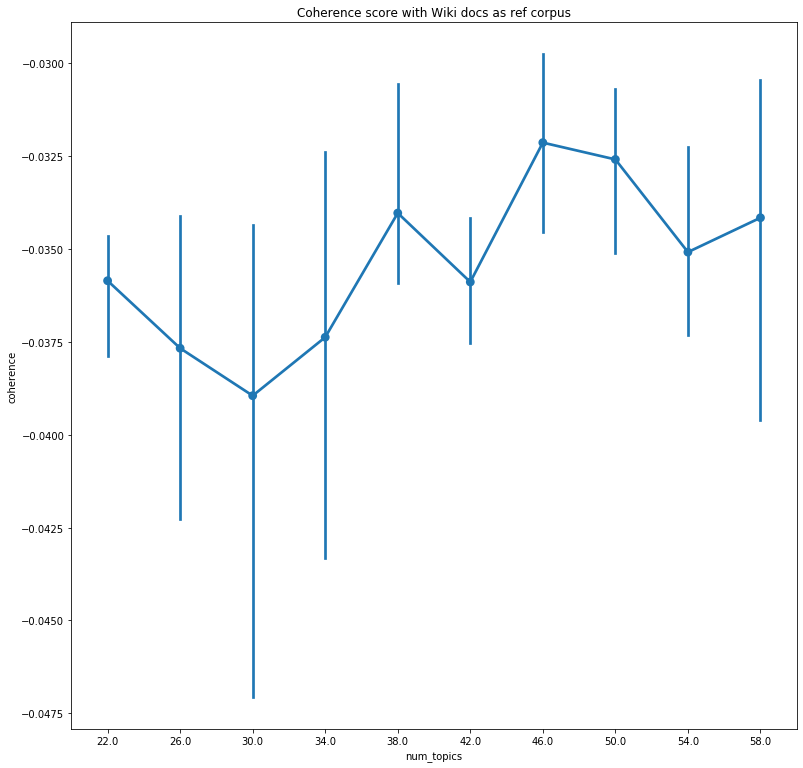

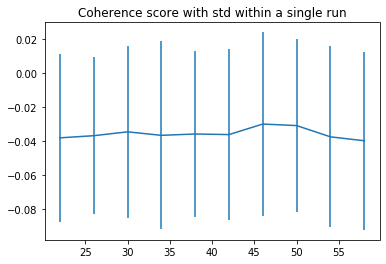

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,13))
plotting_coherence(eval_df)

In [17]:
import pandas as pd

stats = pd.read_csv('LDA_stats.csv')
stats.coherence = stats.coherence/41

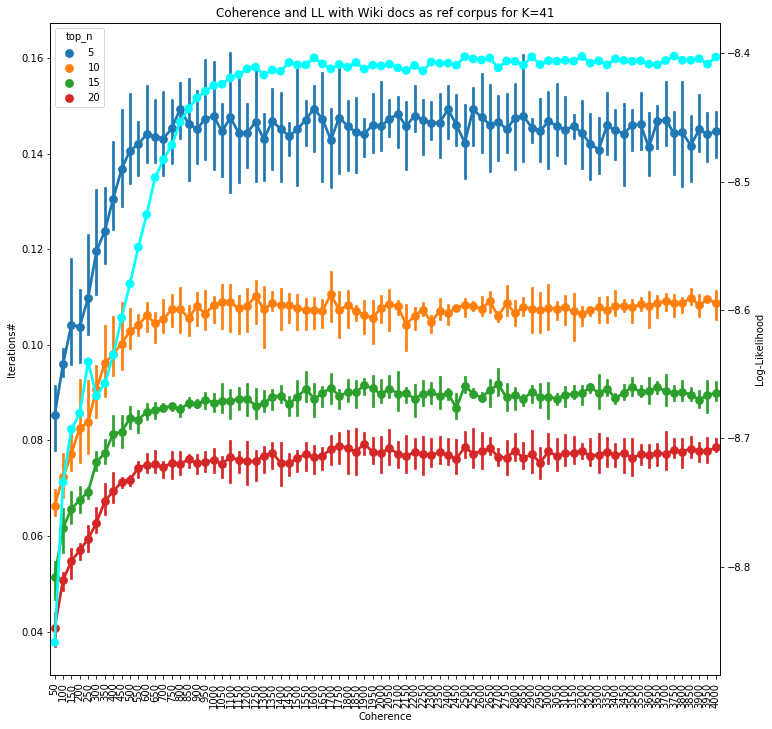

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
topic_num = 41

plt.figure(figsize=(12,12))

ax = sns.pointplot(x='iterations',y='coherence',hue='top_n',data=stats)
ax.set(title='Coherence and LL with Wiki docs as ref corpus for K={0}'.format(topic_num),xlabel='Coherence',ylabel='Iterations#')
ax.tick_params(axis='x', rotation=90)


ax2 = ax.twinx()
sns.pointplot(x='iterations',y='LL',data=stats,color='cyan')
ax2.set(ylabel='Log-Likelihood')
# ax2.y_label('Log-Likelihood')

plt.show()

In [28]:
import numpy as np
import csv

with open('./data/covid_tweets','w',encoding='utf-8') as txtfile:
    with open('./data/tweets_scraped.csv','r',encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile,delimiter=',')
        count = 0
        for line in csv_reader:
            if np.random.random() < 0.25:
                txtfile.write(line[7]+'\n')
                count+=1
        

All coherence compuation for top terms are computed


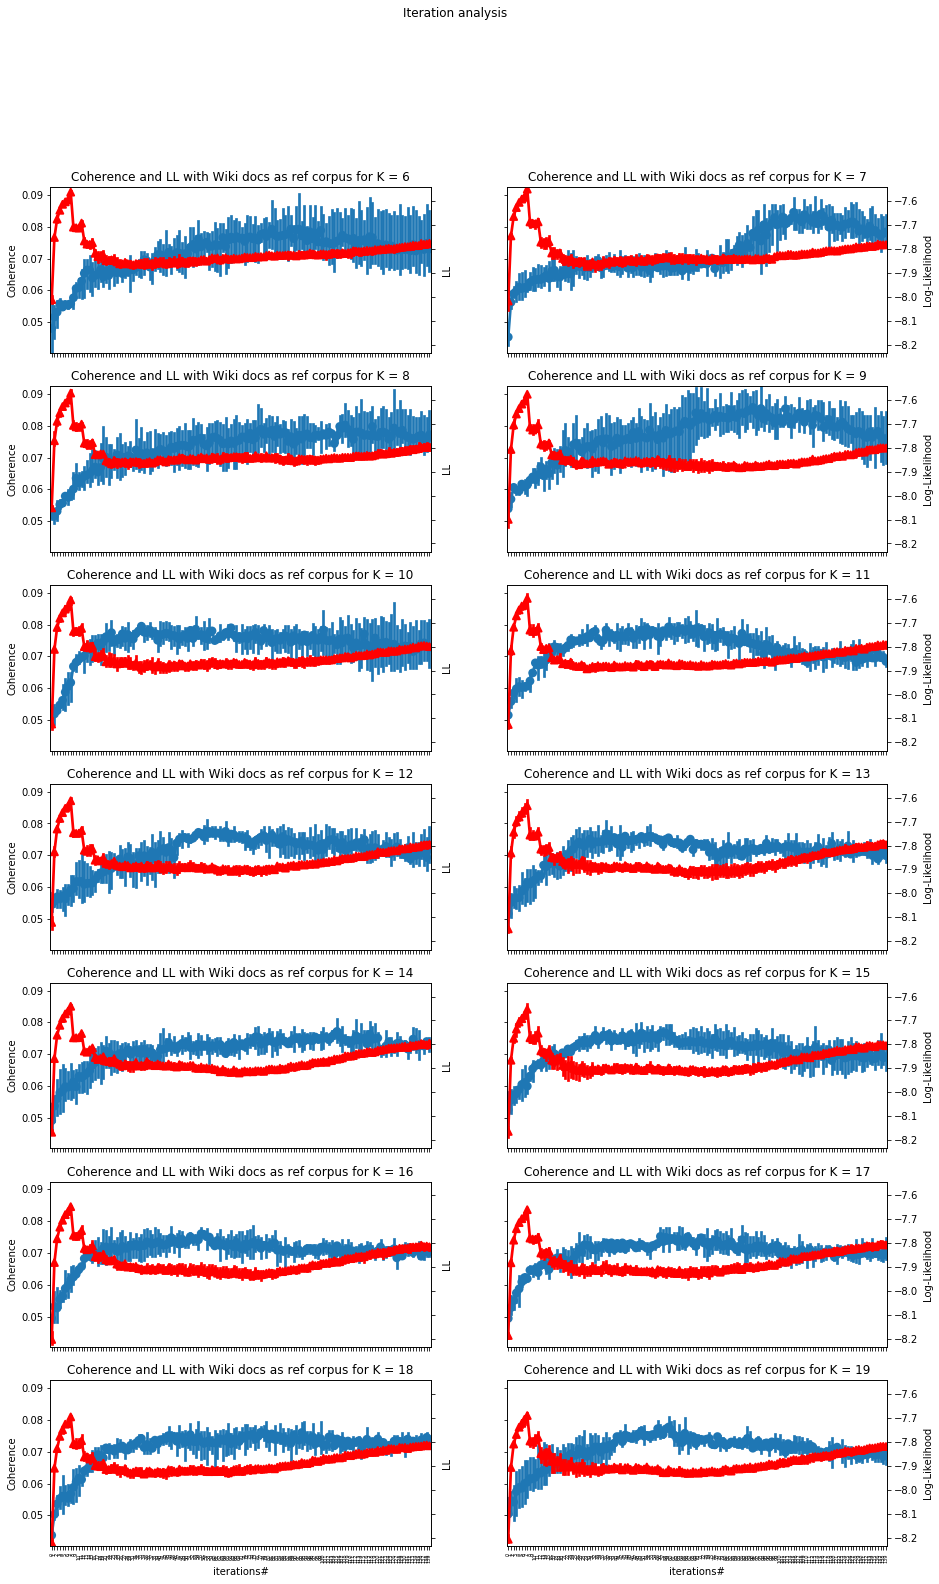

end...


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print('All coherence compuation for top terms are computed')

stats = pd.read_csv('LDA_stats.csv')

# plt.figure(figsize=(15,15))
fig, axes = plt.subplots(7, 2, figsize=(15,25))
fig.suptitle('Iteration analysis')

for i in range(0,7):
    for j in range(0,2):
        ax = sns.pointplot(ax=axes[i,j],x='iterations',y='coherence',data=stats.loc[stats.K==(6+i*2+j),:])
        if i == 6:
            xlabel = 'iterations#'
        else:
            xlabel = ''
        ax.set(title='Coherence and LL with Wiki docs as ref corpus for K = {0}'.format((6+i*2+j)),xlabel=xlabel,ylabel='Coherence')
        ax.tick_params(axis='x', rotation=90)
        ax.set(ylim=(min(stats.coherence),max(stats.coherence)))
        if j == 1:#if the plot is on right, don't print iterations for ylabel to avoid interfere
            ax.set(ylabel='')
            ax.set(yticklabels=[])
        
        ax2 = ax.twinx()
        sns.pointplot(x='iterations',y='LL',data=stats.loc[stats.K==(6+i*2+j),:],markers = '^',color='red')
        ax2.set(ylim=(min(stats.LL),max(stats.LL)))
        if j==1:#if the plot is on the right side, print log-likelihood for ylabel
            ax2.set(ylabel='Log-Likelihood')
        else:
            ax2.set(yticklabels=[])
            
        #decreasing font size for x-ticks
        ax.set_xticklabels(ax.get_xticks(), size = 5)
        
        if i<6:#remove iterations for subplots that are not at the bottom
            ax2.set(xticklabels=[])

# ax = sns.pointplot(x='iterations',y='coherence',hue='K',data=stats.loc[stats.K<11,:])
# ax.set(title='Coherence and LL with Wiki docs as ref corpus for different K',xlabel='Coherence',ylabel='Iterations#')
# ax.tick_params(axis='x', rotation=90)


# ax2 = ax.twinx()
# sns.pointplot(x='iterations',y='LL',hue='K',data=stats.loc[stats.K<11,:],markers = '^')
# ax2.set(ylabel='Log-Likelihood')

plt.show()

fig.savefig('./result/edml/iteration_analysis_multiple_K_EDML.png', format='png', dpi=1200)
fig.savefig('./result/edml/iteration_analysis_multiple_K_EDML.svg', format='svg', dpi=1200)


print('end...')

# bayes search parameter selection

In [2]:
# from lda_mallet import lda_score
# import pickle

# score = lda_score(num_topics=10,alpha=10,optimize_interval=10,iterations=1000,wiki_path='./data/wiki_sampled_10p.txt',
#                   db_path = './db/wiki_10p',vocab_dict_path = './data/corpus.vocab', 
#                   wiki_vocab_dict_path='./data/ref_corpus.vocab',npmi_skip_threshold=0.05)
# score.all_top_terms = [['health','coronavirus','today', 'patients', 'corona', 'vaccine','people', 'feel', 'shit',
#                     'fucking','bc', 'lol', 'gonna', 'fuck', 'love', 'hate', 'make', 'money', 'ass', 'life']]

# with open(score.wiki_vocab_dict_path,'rb') as f:
#     score.wiki_vocab_dict = pickle.load(f)

# with open(score.vocab_dict_path,'rb') as f:
#     score.vocab_dict = pickle.load(f)
# res = score.score([1,2,3])
# res
# # res = score.fit(X)

Load NPMI coherence DB. 
Number of keys : 219025


-0.012348640024849568

In [16]:
# # npmi_db = db('./db/wiki_10p')
# term_pairs = []; cscore = []

# for topic in score.all_top_terms:
#     t = term_pairs_generator(topic)
#     term_pairs.extend(t)
#     cscore.extend([score.npmi_db.get(i) for i in t])

# #check if there is -100 and if we need to run coherence for these pairs
# ind = np.where(np.array(cscore)==-100)
# #if all the terms had a hit in the DB, return the mean
# if len(ind[0]) == 0:
#     np.mean(cscore)

# [[term_pairs[i][0],term_pairs[i][1]] for i in range(len(cscore)) if cscore[i]==-100]

In [8]:
# score.score(X)
# for topic in res:
# #     print(topic)
#     pass
# term_pairs = term_pairs_generator(topic)
# npmi_db = db('./db/wiki_10p/')
# cscore = [npmi_db.get(i) for i in term_pairs]
# print([[term_pairs[i][0],term_pairs[i][1]] for i in range(len(cscore)) if cscore[i]==-100],'-----')

In [1]:
wiki_path = './data/wiki_sampled_10p.txt'

In [2]:
# reading data for ED corpus

import pandas as pd

from pre_processing import *
from lda_mallet import *
from post_processing import *

X = []

#reading pre-processed ED corpus
with open('./data/ed_corpus','r',encoding='utf-8') as txtfile:
    X = txtfile.readlines()
    
len(X)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aminh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Error in setting maxSize for CSV output


5383

In [3]:
#setting wikipedia and removing words from vocab
# loading ref corpus for coherene score for lda_mallet
wiki_docs = loading_wiki_docs(wiki_path)
#doing pre-processing on wiki-pedia documents
pre_processed_wiki, _ = preprocess_data(wiki_docs)
wiki_vocab_dict, _ = prepare_corpus(pre_processed_wiki)


In [4]:
pre_processed_docs,filtered_docs = preprocess_data(X,extra_stopwords={})
#generate vocabulary and texts
vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs)

#finding stopwords that are not in Wikipedia and removing those
extra_stopwords = set(vocab_dict.token2id.keys()).difference(set(wiki_vocab_dict.token2id.keys()))
pre_processed_docs,filtered_docs = preprocess_data(X,extra_stopwords=extra_stopwords)
vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs)

In [5]:
import pickle

wiki_vocab_path = './data/ref_corpus.vocab'
with open(wiki_vocab_path,'wb') as f:
    pickle.dump(wiki_vocab_dict,f)
    
vocab_path = './data/corpus.vocab'
with open(vocab_path,'wb') as f:
    pickle.dump(vocab_dict,f)

In [21]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram
from lda_mallet import lda_score

params = dict()
params['num_topics'] = [10] #this is single-value
params['alpha'] = Integer(65,100)
params['optimize_interval'] = list(range(150,300,10))
params['iterations'] = list(range(3000,8000,50))
params['wiki_path'] = [wiki_path] #this is a constant
params['db_path'] = ['./db/wiki_10p'] #this is a constant
params['vocab_dict_path'] = [vocab_path] #this is a constant
params['wiki_vocab_dict_path'] = [wiki_vocab_path] #this is a constant
params['npmi_skip_threshold'] = [0.05] #this is a single-value

del pre_processed_docs, filtered_docs, vocab_dict#, doc_term_matrix
del wiki_docs, wiki_vocab_dict, pre_processed_wiki

opt = BayesSearchCV(lda_score(),params,n_iter=66)

In [22]:
#fit the optimizer
opt.fit(doc_term_matrix)

Load NPMI coherence DB. 
Number of keys : 219025
skipping 0 missed term-pairs < allowed misses = 0.05
Load NPMI coherence DB. 
Number of keys : 219025
skipping 0 missed term-pairs < allowed misses = 0.05
Load NPMI coherence DB. 
Number of keys : 219025
skipping 0 missed term-pairs < allowed misses = 0.05
Load NPMI coherence DB. 
Number of keys : 219025
skipping 0 missed term-pairs < allowed misses = 0.05
Load NPMI coherence DB. 
Number of keys : 219025
skipping 0 missed term-pairs < allowed misses = 0.05
Load NPMI coherence DB. 
Number of keys : 219025
skipping 0 missed term-pairs < allowed misses = 0.05
Load NPMI coherence DB. 
Number of keys : 219025
skipping 0 missed term-pairs < allowed misses = 0.05
Load NPMI coherence DB. 
Number of keys : 219025
skipping 0 missed term-pairs < allowed misses = 0.05
Load NPMI coherence DB. 
Number of keys : 219025
skipping 0 missed term-pairs < allowed misses = 0.05
Load NPMI coherence DB. 
Number of keys : 219025
skipping 0 missed term-pairs < al

BayesSearchCV(estimator=<lda_mallet.lda_score object at 0x00000188C6164588>,
              n_iter=66,
              search_spaces={'alpha': Integer(low=65, high=100, prior='uniform', transform='normalize'),
                             'db_path': ['./db/wiki_10p'],
                             'iterations': [3000, 3050, 3100, 3150, 3200, 3250,
                                            3300, 3350, 3400, 3450, 3500, 3550,
                                            3600, 3650, 3700, 3750, 3800, 3850,
                                            3900, 3950, 4000, 4050, 4100, 4150,
                                            4200, 4250, 4300, 4350, 4400, 4450, ...],
                             'npmi_skip_threshold': [0.05], 'num_topics': [10],
                             'optimize_interval': [150, 160, 170, 180, 190, 200,
                                                   210, 220, 230, 240, 250, 260,
                                                   270, 280, 290],
                   

In [23]:
print("val. score: %s" % opt.best_score_)
print("best params: %s" % str(opt.best_params_))

val. score: 0.06272563643550169
best params: OrderedDict([('alpha', 99), ('db_path', './db/wiki_10p'), ('iterations', 3750), ('npmi_skip_threshold', 0.05), ('num_topics', 10), ('optimize_interval', 180), ('vocab_dict_path', './data/corpus.vocab'), ('wiki_path', './data/wiki_sampled_10p.txt'), ('wiki_vocab_dict_path', './data/ref_corpus.vocab')])


In [19]:
_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["alpha", "iterations", "optimize_interval"],
                   n_minimum_search=int(1e8))
plt.show()

IndexError: tuple index out of range

<Figure size 432x432 with 9 Axes>

In [16]:
opt.total_iterations

594